# Optimizing Dry Bean Sorting into Classes using Classification with K-nearest neighbors

## Introduction:

Checklist (change)
1. provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report (DONE)
2. clearly state the question you tried to answer with your project (DONE)
3. identify and describe the dataset that was used to answer the question (DONE)



Dry beans, scientifically known as Phaseolus vulgaris L., are a crucially important and widely produced pulse globally (Beebe et al., 2013). In Turkish agriculture, dry beans play a significant role as a dinner table staple in many households. Turkey has several varieties of dry beans, including Barbunya, Battal, Bombay, Calı, Dermason, Horoz, Tombul, Selanik, and Seker. However, the market value of dry beans depends on the specific type of bean, and some beans are sold for higher prices than others.

The cultivation of the seven different beans together makes sorting them a crucial task (Koklu & Ozkan, 2020). Rather than selling them as a mixed batch, farmers can make more profit by sorting them by bean type. Manual classification and sorting of bean seeds can be tedious and time-consuming, especially when dealing with high production volumes. Computer algorithms can analyze images of seeds and classify them based on features like size and shape, making sorting faster, more accurate, and less labor-intensive than manual sorting.

In this project, we are interested in seed classification within the context of our dataset, which identifies the seven different types of dry beans cultivated in Turkey based on their physical features according to the Turkish Standards Institution. This research uses images of seven varieties of dry beans generated by a computer vision system, examining 16 features of the grains (Koklu & Ozkan, 2020). Our aim in this project is to create a k-NN classifier that can classify dry bean seeds.

**Predictive question**: Can we accurately predict bean type (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira) using physical features of the dry beans?

### Variables of Interest:

| Variable Name  | Description                                 |
|--------|---------------------------------------------|
| Area (A)     | The area of a bean zone and the number of pixels within its boundaries.            |
|Perimeter (P)    | Bean circumference is defined as the length of its border.         |
| Major axis length (L)    | The distance between the ends of the longest line that can be drawn from a bean     |
|  Minor axis length (l)    | The longest line that can be drawn from the bean while standing perpendicular to the main axis |
| Aspect ratio (K)     | Defines the relationship between L and l           |
|Eccentricity (Ec)    | Eccentricity of the ellipse having the same moments as the region        |
| Convex area (C)    | Number of pixels in the smallest convex polygon that can contain the area of a bean seed      |
|  Equivalent diameter (Ed)   | The diameter of a circle having the same area as a bean seed area. |
| Extent (Ex)    |The ratio of the pixels in the bounding box to the bean area.            |
|Solidity (S)    | Also known as convexity. The ratio of the pixels in the convex shell to those found in beans          |
| Roundness (R)    |Calculated with the following formula: (4piA)/(P^2)   |
|  Compactness (CO)    | |
| ShapeFactor1 (SF1)    |          |
|ShapeFactor2 (SF2)    |           |
| ShapeFactor3 (SF3)   |       |
|  ShapeFactor4 (SF4)   | |





### Methods & Results:

Checklist
1. loads data from the original source on the web -- (DONE) 
2. wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis -- (DONE) 
3. performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis -- (DONE)
4. creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis -- (DONE)
5. performs the data analysis
6. creates a visualization of the analysis 
7. note: all tables and figure should have a figure/table number and a legend

In [1]:
# Download libraries
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# set seed
set.seed(25)

In [3]:
# Load data 
url <- "https://github.com/NaziaNadir/dsci-100-2023-007-group-8/raw/main/Dry_Bean_Dataset.csv"
bean_data <- read_csv(url)
bean_data

Rows: 13611 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Class
dbl (16): Area, Perimeter, MajorAxisLength, MinorAxisLength, AspectRation, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
29380,624.110,212.8261,175.9311,1.209713,0.5627273,29690,193.4109,0.7781132,0.9895588,0.9478495,0.9087742,0.007243912,0.003047733,0.8258706,0.9990661,SEKER
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
42139,759.321,281.5399,191.1880,1.472582,0.7340648,42569,231.6313,0.7299324,0.9898988,0.9184241,0.8227297,0.006681220,0.001888271,0.6768842,0.9967673,DERMASON
42147,763.779,283.3826,190.2757,1.489326,0.7410548,42667,231.6532,0.7053891,0.9878126,0.9079065,0.8174575,0.006723673,0.001852025,0.6682367,0.9952224,DERMASON
42159,772.237,295.1427,182.2047,1.619841,0.7866930,42600,231.6862,0.7889625,0.9896479,0.8883804,0.7849972,0.007000705,0.001639812,0.6162206,0.9981796,DERMASON


In [4]:
#Wrangle/clean data 

clean_bean_data<-bean_data|>
mutate(Class=as_factor(Class))

clean_bean_data<-na.omit(clean_bean_data)

clean_bean_data

Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
29380,624.110,212.8261,175.9311,1.209713,0.5627273,29690,193.4109,0.7781132,0.9895588,0.9478495,0.9087742,0.007243912,0.003047733,0.8258706,0.9990661,SEKER
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
42139,759.321,281.5399,191.1880,1.472582,0.7340648,42569,231.6313,0.7299324,0.9898988,0.9184241,0.8227297,0.006681220,0.001888271,0.6768842,0.9967673,DERMASON
42147,763.779,283.3826,190.2757,1.489326,0.7410548,42667,231.6532,0.7053891,0.9878126,0.9079065,0.8174575,0.006723673,0.001852025,0.6682367,0.9952224,DERMASON
42159,772.237,295.1427,182.2047,1.619841,0.7866930,42600,231.6862,0.7889625,0.9896479,0.8883804,0.7849972,0.007000705,0.001639812,0.6162206,0.9981796,DERMASON


In [5]:
# Data set exploration summary

In [6]:
# Name of each category in Class column
clean_bean_data |>
  pull(Class) |>
  levels()

[1] "SEKER"    "BARBUNYA" "BOMBAY"   "CALI"     "HOROZ"    "SIRA"     "DERMASON"

In [7]:
# Number and percentage of each category
num_obs <- nrow(clean_bean_data)

bean_number<-clean_bean_data|>
  group_by(Class) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100)
print(bean_number)

# A tibble: 7 × 3
  Class    count percentage
  <fct>    <int>      <dbl>
1 SEKER     2027      14.9 
2 BARBUNYA  1322       9.71
3 BOMBAY     522       3.84
4 CALI      1630      12.0 
5 HOROZ     1928      14.2 
6 SIRA      2636      19.4 
7 DERMASON  3546      26.1 


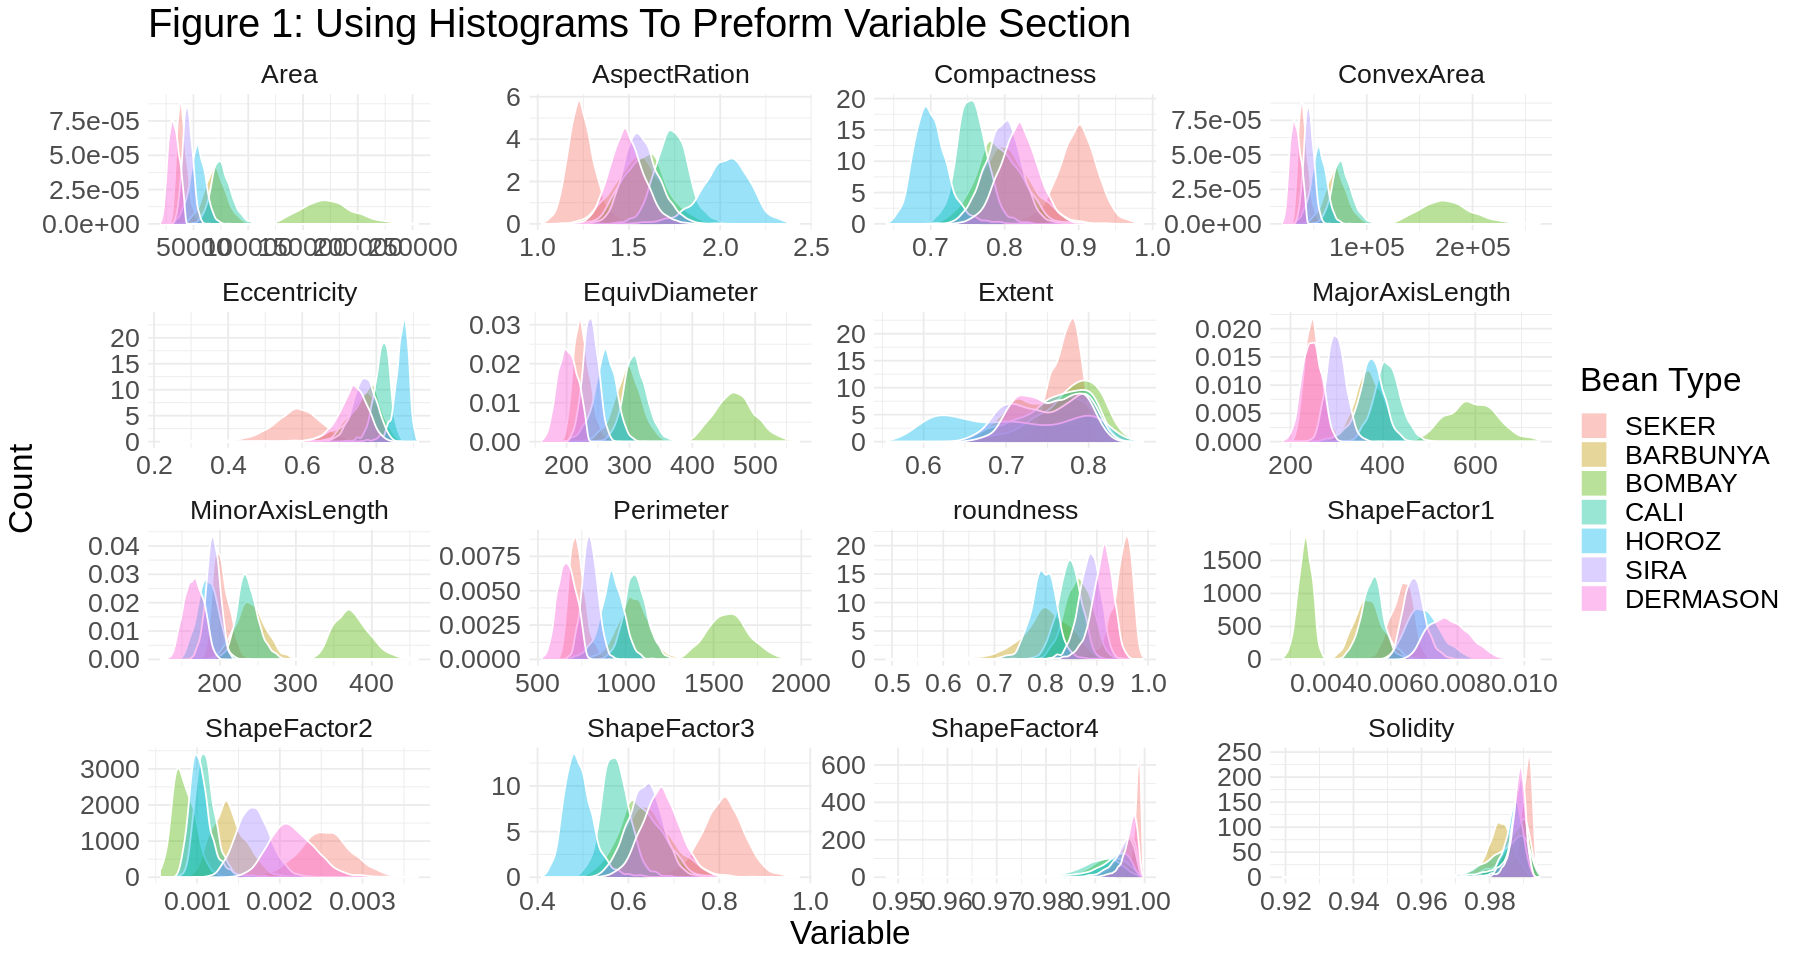

In [8]:
# Predictor selection

options(repr.plot.height = 8, repr.plot.width = 15)
clean_bean_data |>
    pivot_longer(cols = -Class, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = Class)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category), scales = 'free') +
        theme_minimal() +
        labs(x="Variable", y="Count", fill="Bean Type")+
        ggtitle("Figure 1: Using Histograms To Preform Variable Section")+
        theme(text = element_text(size = 20))

To choose our predictors:

First, we removed variables we don't understand. These include shape factors 1, 2, 3, and 4.

Next, we removed variables that convey similar things making them redundant. When it comes to using them as predictors, this will cause our model to place a greater emphasis on those predictors since they're counted twice. 

1. The aspect ratio is the relationship between the major and minor axis of an object. So, we removed the major axis and minor axis. 
2. Area is similar to perimeter. So, we removed the area.

Lastly, we utilized histograms to visualize the distribution of different variables. If the distributions between the graphs greatly overlap then it might not be a good predictor because if an unknown observation was used, it'd be within a cluster of many different bean types. If one distribution was skewed to the right and one distribution was skewed to the left, i.e. very little overlap that could be an indication of a good predictor. Referring to figure 1, distribution of the solidity graph shows notable overlap between every class of bean; thus, this variable was removed.

Therefore, we are left with and will be using the following variables to be used in our classifier:
Area, AspectRation, Compactness, ConvexArea, Eccentricity, EquivDiameter, Extent, Perimeter, and Roundness.


In [9]:
#Update data set
final_bean_data<-clean_bean_data|>
select("Area", "AspectRation", "Compactness", "ConvexArea", "Eccentricity",
       "EquivDiameter", "Extent", "Perimeter", "roundness", "Class")
final_bean_data

Area,AspectRation,Compactness,ConvexArea,Eccentricity,EquivDiameter,Extent,Perimeter,roundness,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28395,1.197191,0.9133578,28715,0.5498122,190.1411,0.7639225,610.291,0.9580271,SEKER
28734,1.097356,0.9538608,29172,0.4117853,191.2728,0.7839681,638.018,0.8870336,SEKER
29380,1.209713,0.9087742,29690,0.5627273,193.4109,0.7781132,624.110,0.9478495,SEKER
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
42139,1.472582,0.8227297,42569,0.7340648,231.6313,0.7299324,759.321,0.9184241,DERMASON
42147,1.489326,0.8174575,42667,0.7410548,231.6532,0.7053891,763.779,0.9079065,DERMASON
42159,1.619841,0.7849972,42600,0.7866930,231.6862,0.7889625,772.237,0.8883804,DERMASON


### k-NN Classification Model

In [10]:
#Create the train/ test split
bean_split <- initial_split(final_bean_data, prop = 0.50, strata = Class)
bean_train <- training(bean_split)
bean_test <- testing(bean_split)

In [11]:
glimpse(bean_train)

Rows: 6,804
Columns: 10
$ Area          <dbl> 43145, 47149, 49755, 50167, 50575, 51015, 52839, 53525, …
$ AspectRation  <dbl> 1.358410, 1.499042, 1.729713, 1.498715, 1.529822, 1.6516…
$ Compactness   <dbl> 0.8572690, 0.8159311, 0.7579074, 0.8155538, 0.8073124, 0…
$ ConvexArea    <dbl> 43812, 48091, 50783, 50937, 51389, 51718, 53489, 54660, …
$ Eccentricity  <dbl> 0.6768132, 0.7449746, 0.8159441, 0.7448443, 0.7567789, 0…
$ EquivDiameter <dbl> 234.3799, 245.0142, 251.6943, 252.7343, 253.7599, 254.86…
$ Extent        <dbl> 0.7661233, 0.7207674, 0.7342828, 0.7945989, 0.7121233, 0…
$ Perimeter     <dbl> 799.426, 857.690, 868.813, 873.825, 858.520, 859.253, 88…
$ roundness     <dbl> 0.8483671, 0.8054186, 0.8283120, 0.8256178, 0.8622733, 0…
$ Class         <fct> BARBUNYA, BARBUNYA, BARBUNYA, BARBUNYA, BARBUNYA, BARBUN…


In [12]:
glimpse(bean_test)

Rows: 6,807
Columns: 10
$ Area          <dbl> 28395, 30008, 30279, 30519, 30685, 30917, 31091, 31107, …
$ AspectRation  <dbl> 1.197191, 1.153638, 1.171067, 1.165591, 1.165852, 1.1578…
$ Compactness   <dbl> 0.9133578, 0.9283288, 0.9237260, 0.9254804, 0.9256585, 0…
$ ConvexArea    <dbl> 28715, 30724, 30600, 30847, 31044, 31280, 31458, 31423, …
$ Eccentricity  <dbl> 0.5498122, 0.4986160, 0.5204007, 0.5137596, 0.5140809, 0…
$ EquivDiameter <dbl> 190.1411, 195.4671, 196.3477, 197.1243, 197.6597, 198.40…
$ Extent        <dbl> 0.7639225, 0.7826813, 0.7756885, 0.7706818, 0.7715615, 0…
$ Perimeter     <dbl> 610.291, 645.884, 634.927, 629.727, 635.681, 640.765, 63…
$ roundness     <dbl> 0.9580271, 0.9039364, 0.9438518, 0.9671092, 0.9542398, 0…
$ Class         <fct> SEKER, SEKER, SEKER, SEKER, SEKER, SEKER, SEKER, SEKER, …


We can observe from glimpse in the code above that the training set contains 6805 observations, while the test set contains 6806 observations. This corresponds to a train / test split of 50% / 50%, as desired.

In [13]:
# K value selection

In [14]:
bean_vfold <- vfold_cv(bean_train, v = 5, strata = Class)

In [15]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [16]:
bean_recipe <- recipe(Class ~ ., data = bean_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
bean_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          9

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [17]:
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))
k_vals

neighbors
<dbl>
1
2
3
⋮
18
19
20


In [21]:
knn_results <- workflow() |>
  add_recipe(bean_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = bean_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8838931,5,0.002442234,Preprocessor1_Model01
2,accuracy,multiclass,0.8838931,5,0.002442234,Preprocessor1_Model02
3,accuracy,multiclass,0.9034447,5,0.004020332,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,multiclass,0.9137351,5,0.004914317,Preprocessor1_Model18
19,accuracy,multiclass,0.9144695,5,0.004922190,Preprocessor1_Model19
20,accuracy,multiclass,0.9137343,5,0.004796068,Preprocessor1_Model20


In [1]:
accuracies_max <- accuracies |>
arrange(mean)|>
tail(1)
accuracies_max

ERROR: Error in arrange(accuracies, mean): could not find function "arrange"


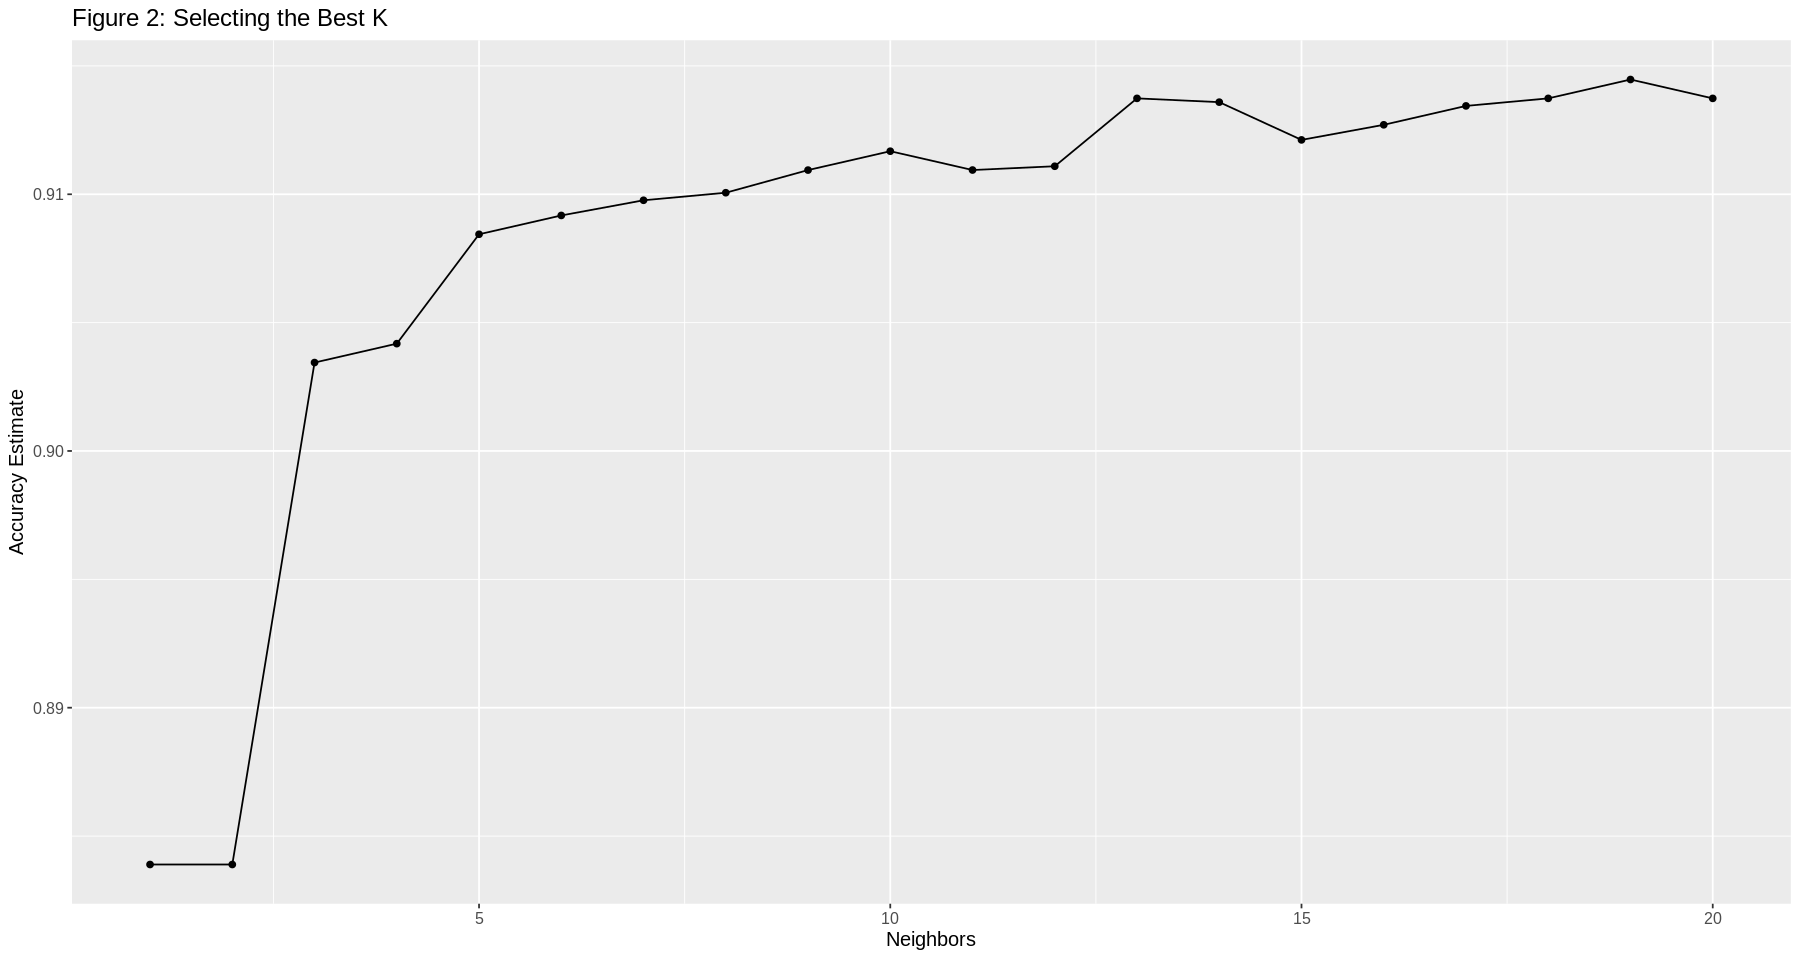

In [22]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))+
ggtitle("Figure 2: Selecting the Best K")

accuracy_vs_k

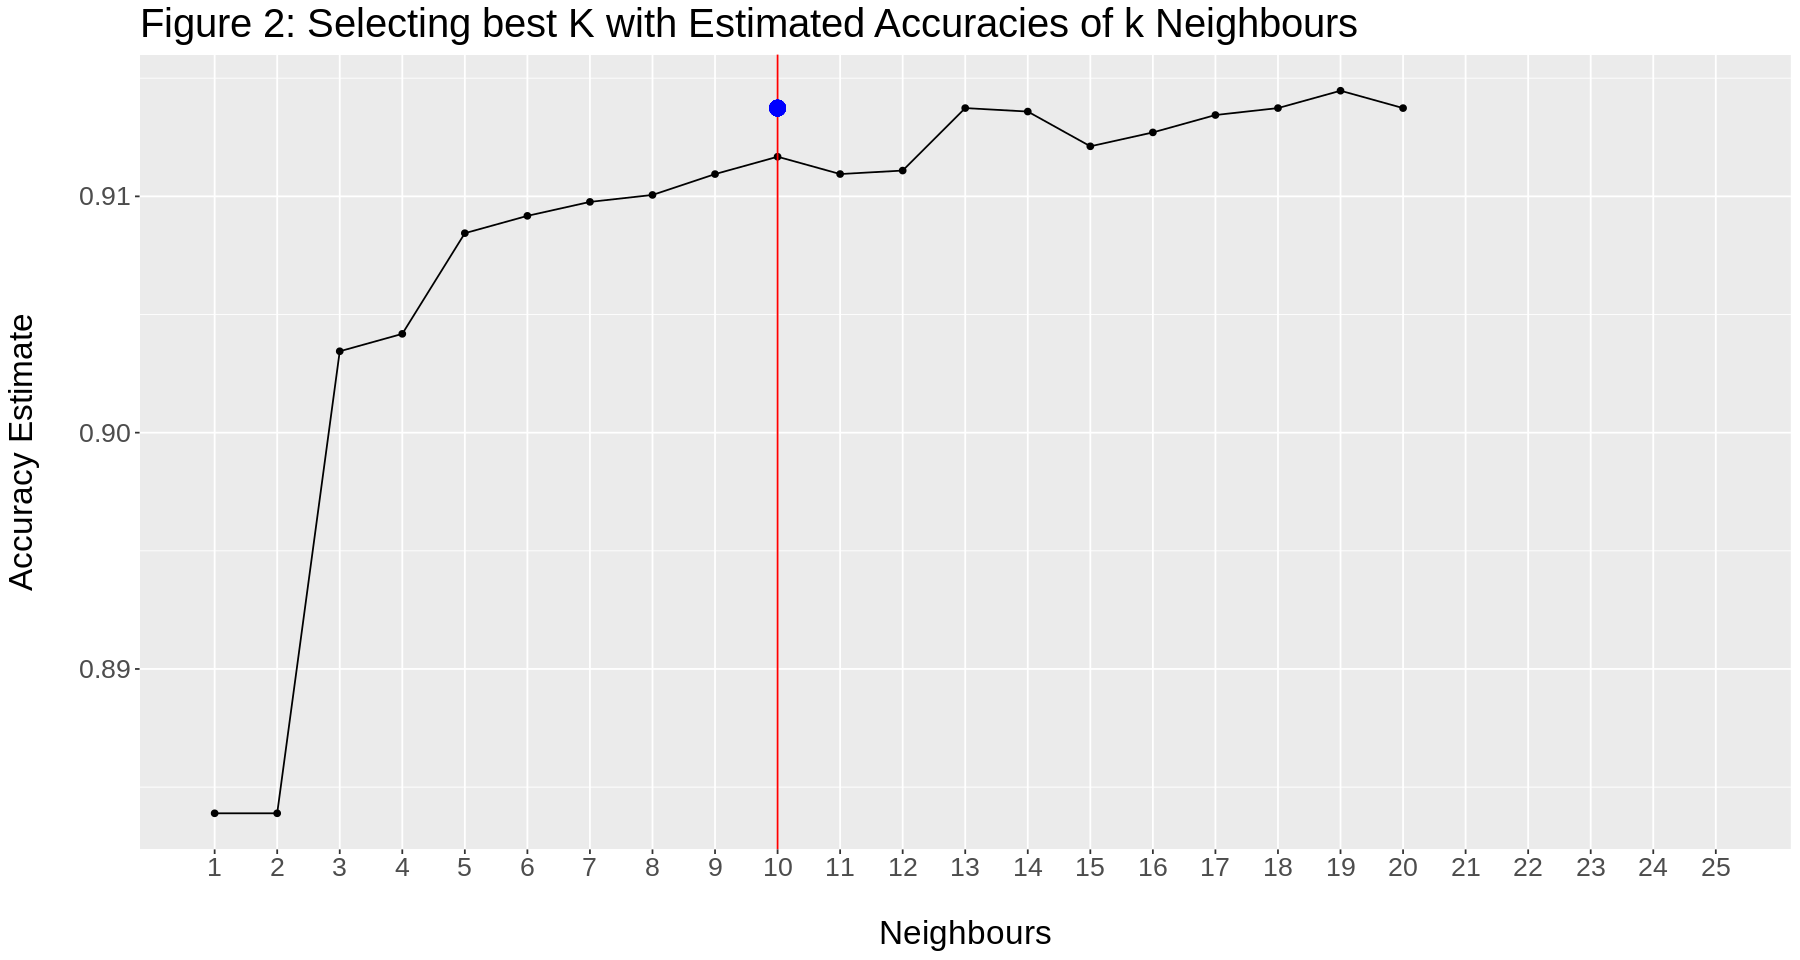

In [23]:
#NOTE: I added this version of the cross validation plot to see if it may be visually better
#Adjust the k value if we change best k = 10 to something else
ky <- accuracies |>
    filter(neighbors == 13) |>
    select(mean) |>
    pull()

cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 10, colour = "red") +
    geom_point(aes(x = 10, y = ky), size = 4, colour = "blue") +
    labs(x = "\nNeighbours",
         y = "Accuracy Estimate\n",
         title = "Figure 2: Selecting best K with Estimated Accuracies of k Neighbours") +
    scale_x_continuous(limits = c(1, 25),
                       breaks = seq(1, 25),
                       minor_breaks = seq(1, 25, 1)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))

cross_val_plot

Based on the findings presented in Figure 2, it can be concluded that a value of k=10 provides the highest estimated accuracy. Moreover, the graph indicates that the estimated accuracy remains relatively stable even if we slightly increase or decrease k around the value of 10. Furthermore, selecting k=10 does not result in a computationally expensive training process. Therefore, taking all these factors into consideration, we would choose k=10 as the optimal value for the classifier.

In [ ]:
# Make a new model specification for the best parameter value 

In [ ]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(bean_recipe) |>
  add_model(knn_spec) |>
  fit(data = bean_train)
knn_fit

In [ ]:
# Evaluate the estimated accuracy of the classifier 

In [ ]:
bean_predictions <- predict(knn_fit, bean_test) |>
  bind_cols(bean_test)|>
mutate(Class = as_factor(Class))

bean_predictions

In [ ]:
levels(bean_predictions$.pred_class) <- levels(bean_predictions$Class)
bean_predictions |>
metrics(truth = Class, estimate =.pred_class)|>
filter(.metric == "accuracy")

In [ ]:
confusion <- bean_predictions |>
             conf_mat(truth = Class, estimate = .pred_class)
confusion

### Discussion:

Checklist 
1. summarize what you found
2. discuss whether this is what you expected to find?
3. discuss what impact could such findings have?
4. discuss what future questions could this lead to?

### References

Checklist
1. At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
2. Make sure to cite the source of your data as well.


Beebe, S. E., Rao, I. M., Blair, M. W., & Acosta-Gallegos, J. A. (2013). Phenotyping common beans for adaptation to drought. Frontiers in Physiology, 4, 35-35. https://doi.org/10.3389/fphys.2013.00035

Koklu, M., & Ozkan, I. A. (2020). Multiclass classification of dry beans using computer vision and machine learning techniques. Computers and Electronics in Agriculture, 174, 105507. https://doi.org/10.1016/j.compag.2020.105507